In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load the dataset
data_path = "https://raw.githubusercontent.com/sravanipullayagari/ML/refs/heads/main/SampleSuperstore.csv" 
data = pd.read_csv(data_path)
data.head()

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164


In [7]:
# Data Cleaning Process

# Check and drop missing values
print("Missing Values Before Cleaning:")
print(data.isnull().sum())
data = data.dropna()
print(f"Missing Values After Cleaning: {data.isnull().sum().sum()}")

# Remove duplicate rows
print(f"Duplicate Rows Before Cleaning: {data.duplicated().sum()}")
data = data.drop_duplicates()
print(f"Duplicate Rows After Cleaning: {data.duplicated().sum()}")

# Remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in ['Sales', 'Profit']:
    data = remove_outliers(data, col)

# Ensure 'Discount' is between 0 and 1
if data['Discount'].max() > 1:
    data['Discount'] = data['Discount'] / 100
    
# Convert categorical features to string type (if needed)
categorical_cols = ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Region', 'Category', 'Sub-Category']
for col in categorical_cols:
    data[col] = data[col].astype(str)

# Final summary of the cleaned data
print(f"Shape After Cleaning: {data.shape}")
print("First few rows of the cleaned data:")
print(data.head())


Missing Values Before Cleaning:
Ship Mode       0
Segment         0
Country         0
City            0
State           0
Postal Code     0
Region          0
Category        0
Sub-Category    0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64
Missing Values After Cleaning: 0
Duplicate Rows Before Cleaning: 17
Duplicate Rows After Cleaning: 0
Shape After Cleaning: (7382, 13)
First few rows of the cleaned data:
        Ship Mode    Segment        Country             City       State  \
0    Second Class   Consumer  United States        Henderson    Kentucky   
2    Second Class  Corporate  United States      Los Angeles  California   
4  Standard Class   Consumer  United States  Fort Lauderdale     Florida   
5  Standard Class   Consumer  United States      Los Angeles  California   
6  Standard Class   Consumer  United States      Los Angeles  California   

   Postal Code Region         Category Sub-Category    Sales  Quantity  \
0        42420  Sout

**General Overview of the Dataset**

In [10]:
# General overview of the dataset
print("Dataset Shape:", data.shape)
print("\nDataset Info:")
print(data.info())
print("\nDataset Description:")
print(data.describe())

Dataset Shape: (7382, 13)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 7382 entries, 0 to 9992
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Ship Mode     7382 non-null   object 
 1   Segment       7382 non-null   object 
 2   Country       7382 non-null   object 
 3   City          7382 non-null   object 
 4   State         7382 non-null   object 
 5   Postal Code   7382 non-null   int64  
 6   Region        7382 non-null   object 
 7   Category      7382 non-null   object 
 8   Sub-Category  7382 non-null   object 
 9   Sales         7382 non-null   float64
 10  Quantity      7382 non-null   int64  
 11  Discount      7382 non-null   float64
 12  Profit        7382 non-null   float64
dtypes: float64(3), int64(2), object(8)
memory usage: 807.4+ KB
None

Dataset Description:
        Postal Code        Sales     Quantity     Discount       Profit
count   7382.000000  7382.000000  7382.000000  73

**Univariate Analysis: Distribution of Numerical Columns**

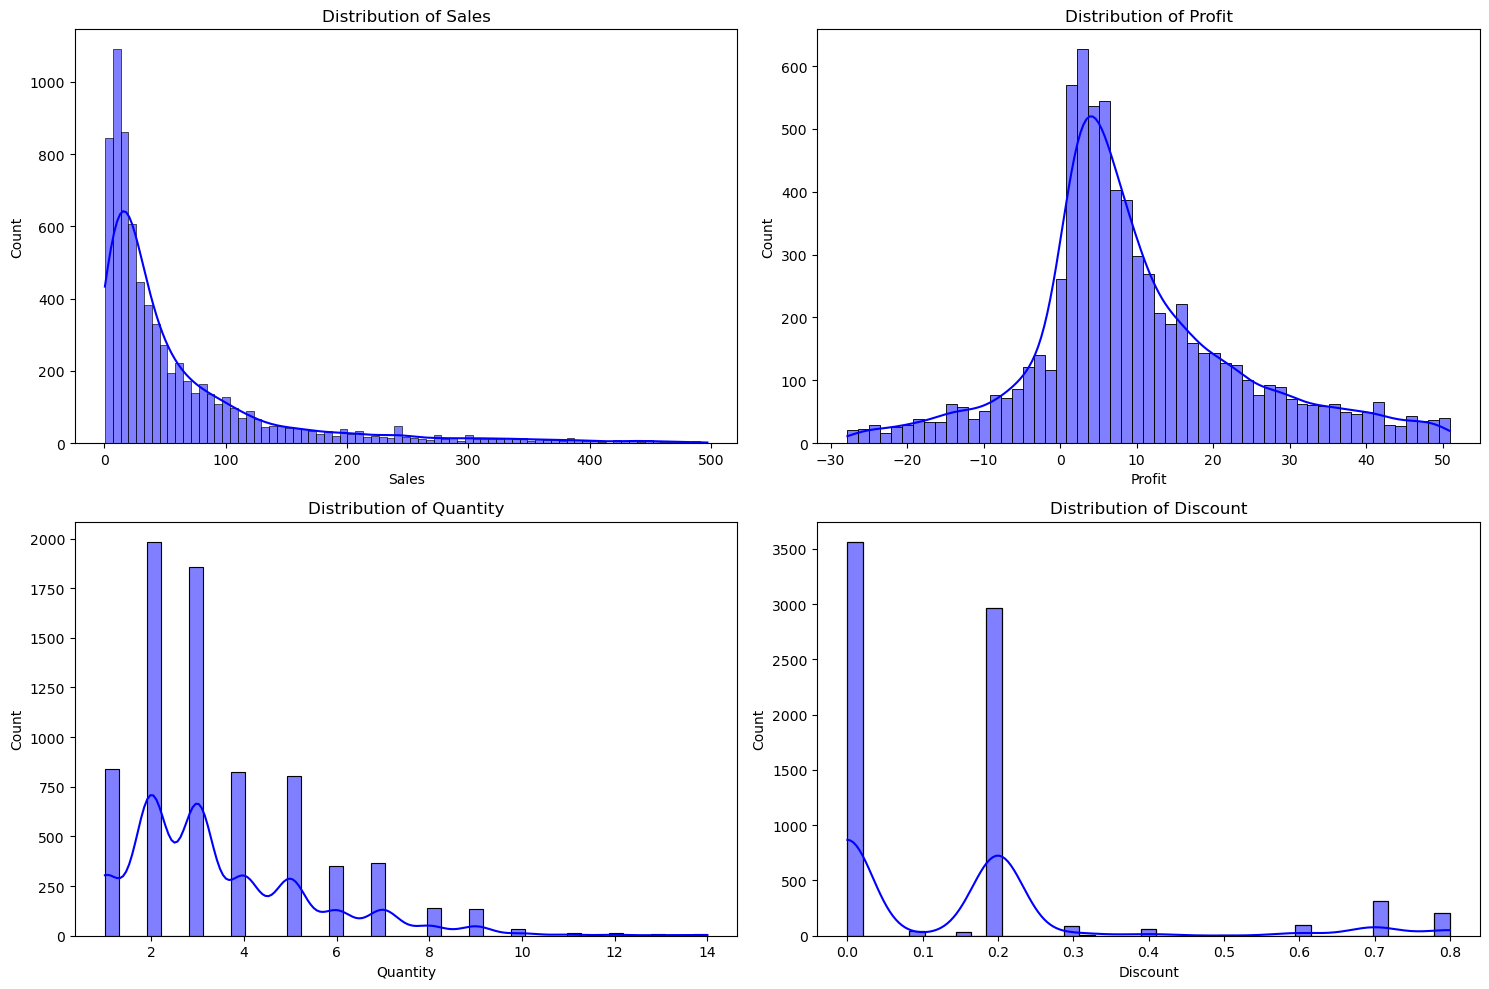

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of numerical columns
numerical_features = ['Sales', 'Profit', 'Quantity', 'Discount']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[feature], kde=True, color='blue')
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

**Bivariate Analysis: Correlation Heatmap**

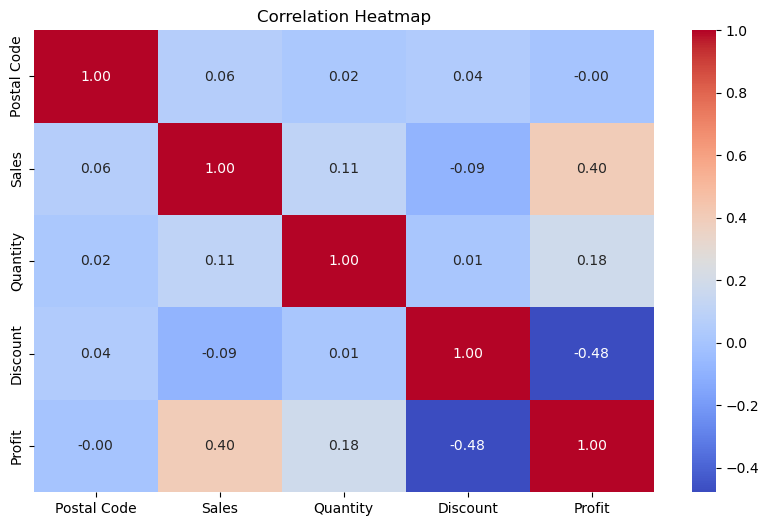

In [16]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**Categorical Feature Analysis: Count Plots**

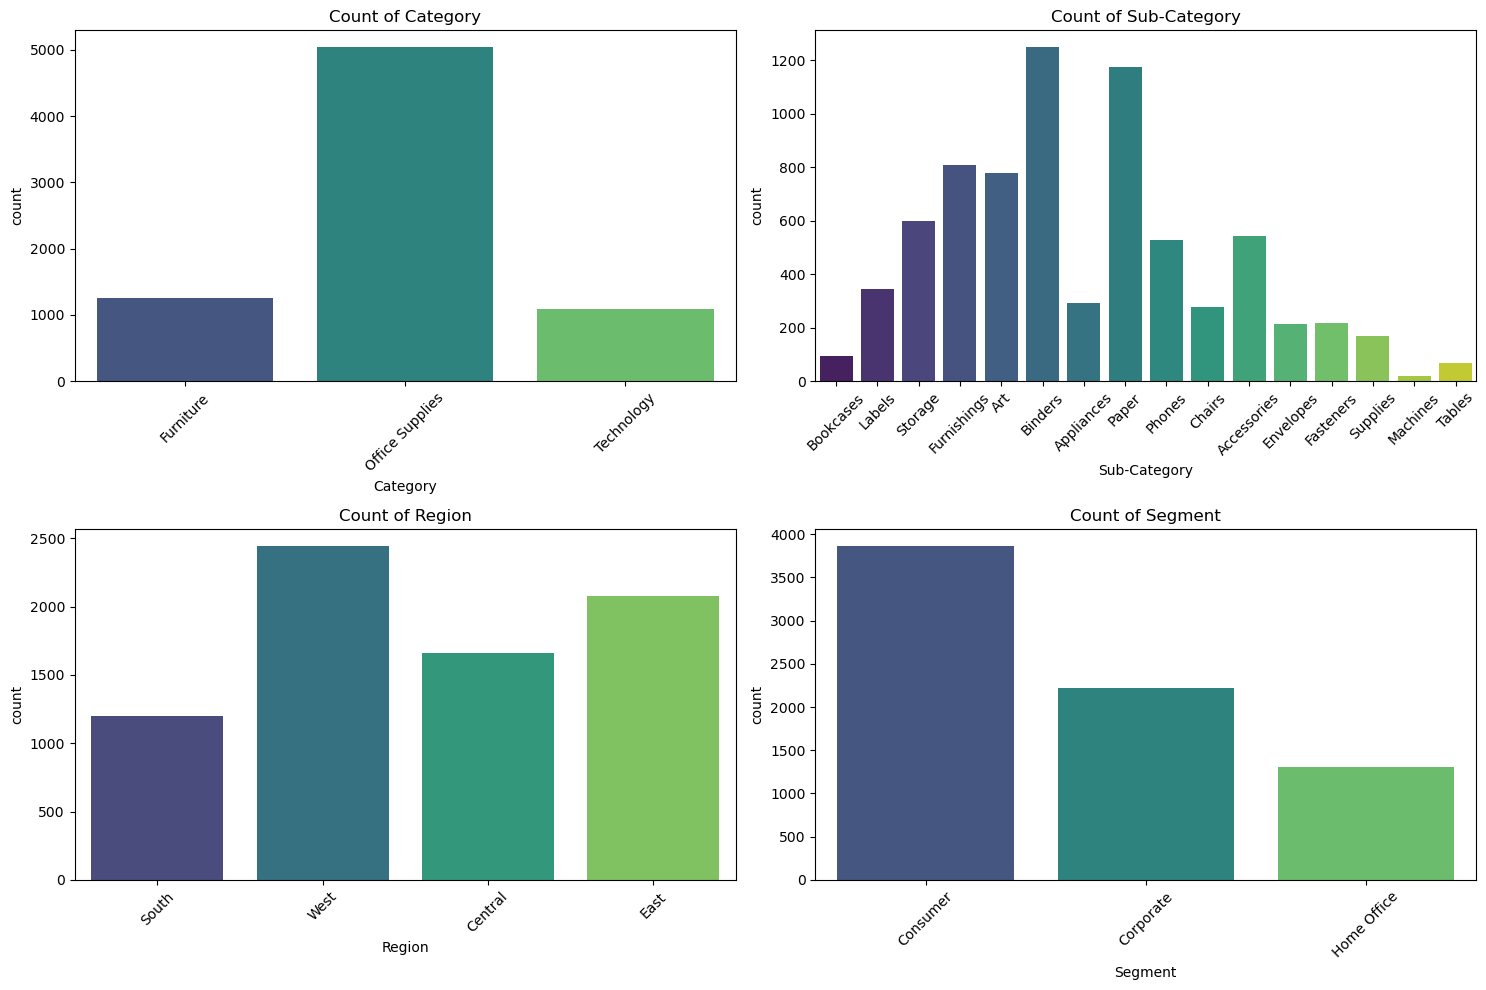

In [19]:
# Count plots for categorical features
categorical_features = ['Category', 'Sub-Category', 'Region', 'Segment']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=data, x=feature, palette='viridis')
    plt.title(f"Count of {feature}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Profit Analysis by Category**

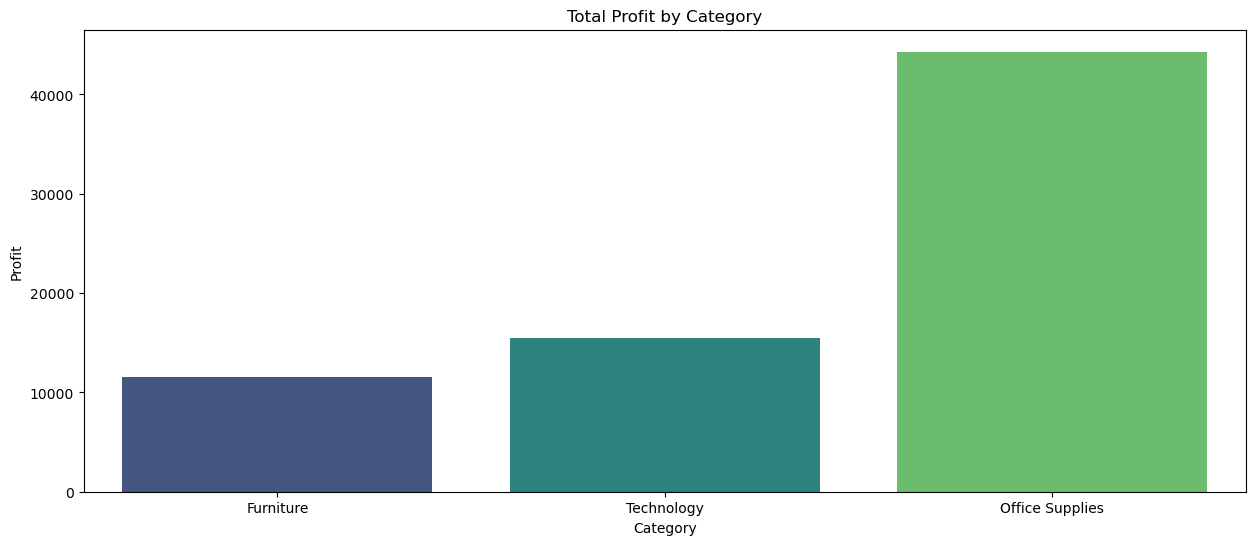

In [22]:
# Profit by Category
plt.figure(figsize=(15, 6))
category_profit = data.groupby('Category')['Profit'].sum().sort_values()
sns.barplot(x=category_profit.index, y=category_profit.values, palette='viridis')
plt.title("Total Profit by Category")
plt.xlabel("Category")
plt.ylabel("Profit")
plt.show()

**Profit Analysis by Sub-Category**

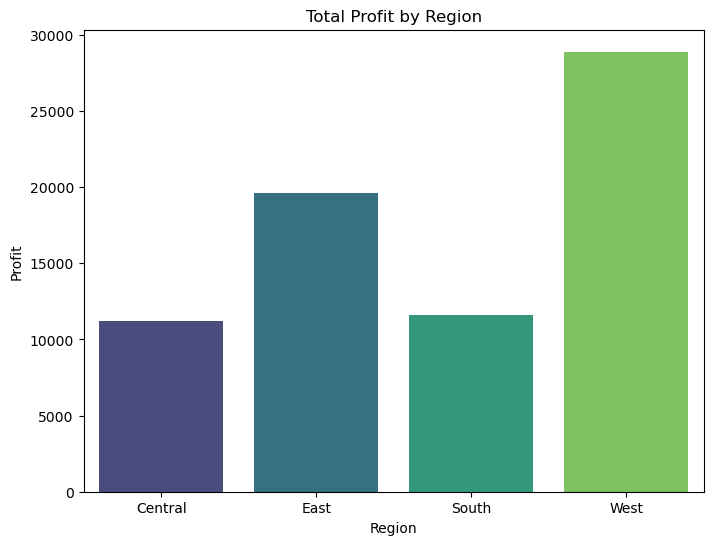

In [25]:
# Profit by Region
plt.figure(figsize=(8, 6))
region_profit = data.groupby('Region')['Profit'].sum()
sns.barplot(x=region_profit.index, y=region_profit.values, palette='viridis')
plt.title("Total Profit by Region")
plt.xlabel("Region")
plt.ylabel("Profit")
plt.show()

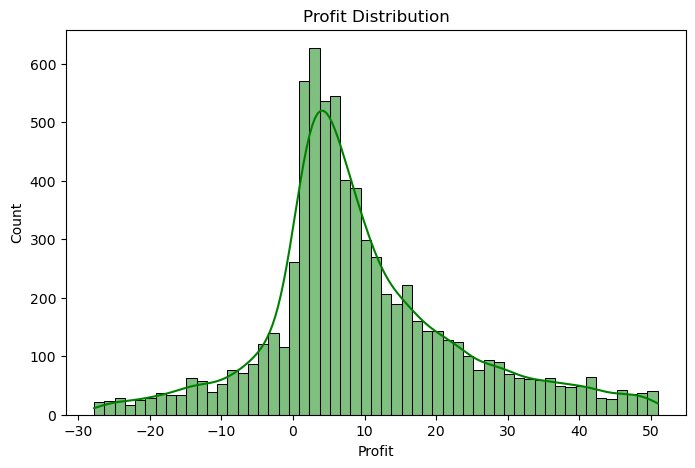

In [27]:
# Profit distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['Profit'], kde=True, color='green')
plt.title("Profit Distribution")
plt.xlabel("Profit")
plt.show()


**Preprocessing**

**Define Features and Target**

In [31]:
# Define X (features) and y (target)
X = data.drop(columns=['Profit'])
y = data['Profit']

**Preprocessor for Numerical and Categorical Data**

In [34]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

 **Modeling**

**Split Data**

In [38]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# --- Model Training and Evaluation ---
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = {}

# Evaluate models
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Performance:")
    print(f"  Mean Squared Error: {mse:.5f}")
    print(f"  R^2 Score: {r2:.5f}")
    print("-" * 30)

Random Forest & Gradient Boosting are the best models with R^2 score 0.70 which means 70% & 0.72 which means 72% of the data was predicting by the model and the mean squared value is near to the actual values.

In [42]:
# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Define the parameter grid
param_dist = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Randomized search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter combinations to try
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best model and evaluation
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': 30}
Mean Squared Error: 50.68
R^2 Score: 0.74


**Visualize Feature Importance**

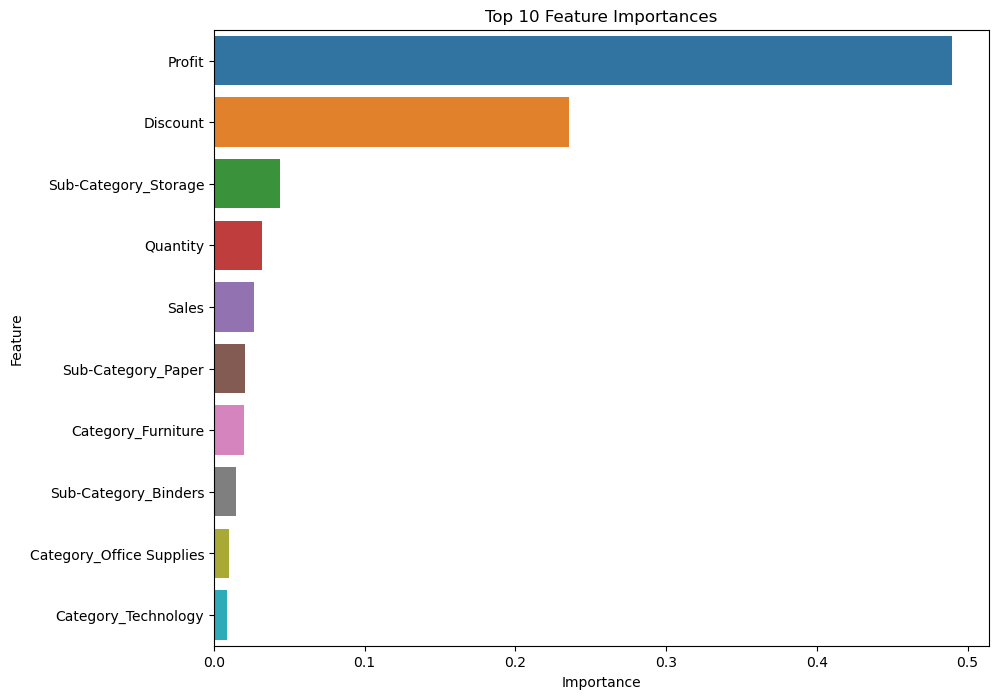

In [44]:
# Extract the RandomForest model and preprocessor from the pipeline
rf_model = best_model.named_steps['model']
preprocessor = best_model.named_steps['preprocessor']

# Get feature names (numerical + encoded categorical)
encoded_categorical_cols = preprocessor.transformers_[1][1].get_feature_names_out()
feature_names = numerical_features + list(encoded_categorical_cols)
# Get feature importances
importances = rf_model.feature_importances_

# Sort features by importance and filter the top N
top_n = 10  # Set the number of top features to display
sorted_idx = importances.argsort()[::-1]  # Sort indices by importance, descending
top_idx = sorted_idx[:top_n]  # Get indices of top N features
top_importances = importances[top_idx]
top_feature_names = [feature_names[i] for i in top_idx]

# Optionally, apply log scale to the importance values if needed
# top_importances_log = np.log1p(top_importances)

# Plot top N feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=top_importances, y=top_feature_names)
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [45]:
# Find the best model
best_model_name = max(results, key=lambda x: results[x]["R2"])
best_model = models[best_model_name]

print(f"\nThe best model is: {best_model_name} with R-Squared: {results[best_model_name]['R2']}")

# --- Hyperparameter Tuning for the Best Model ---
if best_model_name == "Random Forest":
    param_grid_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rf_random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                          param_distributions=param_grid_rf,
                                          n_iter=10, cv=3, scoring='r2', n_jobs=-1, random_state=42)
    rf_random_search.fit(X_train, y_train)
    best_rf = rf_random_search.best_estimator_
    print("\nBest Hyperparameters for Random Forest:", rf_random_search.best_params_)

elif best_model_name == "Gradient Boosting":
    param_grid_gb = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
    gb_random_search = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                                          param_distributions=param_grid_gb,
                                          n_iter=10, cv=3, scoring='r2', n_jobs=-1, random_state=42)
    gb_random_search.fit(X_train, y_train)
    best_gb = gb_random_search.best_estimator_
    print("\nBest Hyperparameters for Gradient Boosting:", gb_random_search.best_params_)

ValueError: max() arg is an empty sequence

In [ ]:


# --- Feature Importance (For Tree-Based Models) ---
if best_model_name in ["Random Forest", "Gradient Boosting"]:
    feature_importance = pd.DataFrame({'Feature': features, 
                                       'Importance': best_model.feature_importances_})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
    plt.title(f"Feature Importance ({best_model_name})")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()


In [ ]:
# --- Final Evaluation ---
if best_model_name == "Random Forest":
    y_pred_best = best_rf.predict(X_test)
elif best_model_name == "Gradient Boosting":
    y_pred_best = best_gb.predict(X_test)
else:
    y_pred_best = best_model.predict(X_test)

final_mse = mean_squared_error(y_test, y_pred_best)
final_r2 = r2_score(y_test, y_pred_best)

print("\nFinal Evaluation of the Best Model:")
print(f"Mean Squared Error: {final_mse}")
print(f"R-Squared: {final_r2}")
